__Linking Phases__

So, we've learnt that if our parameter space is too complex, our non-linear search might fail to find the global maximum solution. However, we also learnt how to ensure this doesn't happen, by:

1) Tuning our priors to the strong lens we're fitting.

2) Making our lens model less complex.

3) Searching non-linear parameter space for longer.

However, each of the above approaches has disadvantages. The more we tune our priors, the less we can generalize our analysis to a different strong lens. The less complex we make our model, the less realistic it is. And if we rely too much on searching parameter space for longer, we could end up with phase's that take days, weeks or months to run.

In this exercise, we're going to combine these 3 approaches, so that we can fit complex and realistic lens models in a way that that can be generalized to many different strong lenses. To do this, we'll run 2 phases, and link the lens model inferred in the first phase to the priors of the second phase's lens model.

Our first phase will make the same light-traces-mass assumption we made in the previous tutorial. We saw that this gives a reasonable lens model. However, we'll make a couple of extra simplifying assumptions, to really try and bring our lens model complexity down and get the non-linear search running fast.

The model we infer above will therefore be a lot less realistic. But it doesn't matter, because in the second phase we're going to relax these assumptions and get back our more realistic lens model. The beauty is that, by running the first phase, we can use its results to tune the priors of our second phase. For example:

1) The first phase should give us a pretty good idea of the lens galaxy's light and mass profiles, for example its intensity, effective radius and einstein radius.

2) It should also give us a pretty good fit to the lensed source galaxy. This means we'll already know where in source-plane its is located and what its intensity and effective are.

In [1]:
%matplotlib inline

from autofit import conf
from autofit.optimize import non_linear as nl
from autofit.mapper import model_mapper as mm
from autolens.pipeline import phase as ph
from autolens.model.galaxy import galaxy_model as gm
from autolens.data import ccd
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters
from autolens.lens.plotters import lens_fit_plotters

In [7]:
# You need to change the path below to the chapter 1 directory.
chapter_path = '/path/to/user/autolens_workspace/howtolens/chapter_2_lens_modeling/'
chapter_path = '/home/jammy/PycharmProjects/PyAutoLens/workspace/howtolens/chapter_2_lens_modeling/'

# This sets up the config files used by this tutorial, and the path where the output of the modeling is placed.
conf.instance = conf.Config(config_path=chapter_path+'configs/5_linking_phases', output_path=chapter_path+"output")

Another simulate image function, for the same image again.

In [8]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)
    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                             effective_radius=0.5, sersic_index=3.5),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8))

    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.5, phi=90.0, intensity=0.03,
                                                       effective_radius=0.3, sersic_index=3.0))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    image_simulated = ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                         exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated


Simulate the image and set it up.

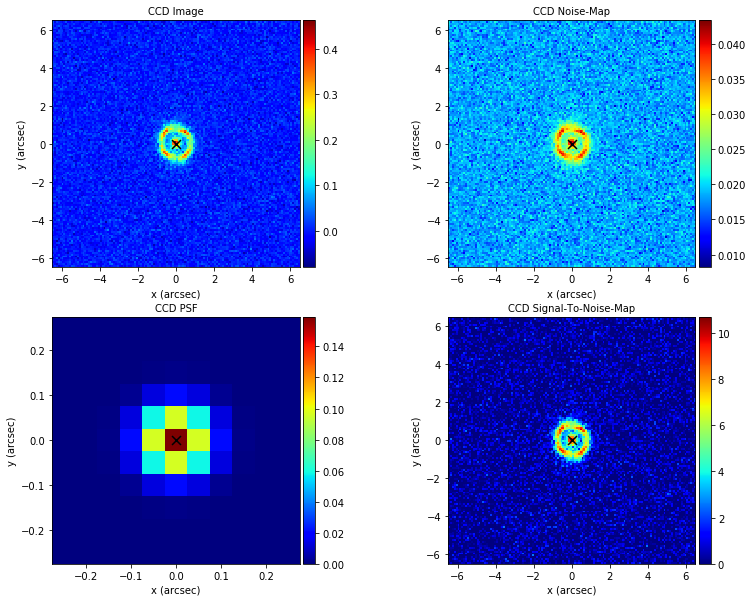

In [11]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

Lets use the same LightTracesMass Phase that we did previously, but we'll make it slightly less complex then before.

In [12]:
class LightTracesMassPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, results):

        # As we've eluded to before, one can look at an image and immediately identify the centre of the lens
        # galaxy. It's that bright blob of light surrounded by the lensed source galaxy! Given that we know we're going
        # to make the lens model more complex in the next phase, lets take a liberal approach to the lens centre and
        # fix it to (y,x) = (0.0", 0.0").

        # You haven't actually seen a line like this one before. By setting a parameter to a number (and not a prior),
        # it is be removed from non-linear parameter space and always fixed to that value. Pretty neat, huh?
        self.lens_galaxies.lens.light.centre_0 = 0.0
        self.lens_galaxies.lens.light.centre_1 = 0.0
        self.lens_galaxies.lens.mass.centre_0 = 0.0
        self.lens_galaxies.lens.mass.centre_1 = 0.0

        # Now, you might be thinking, doesn't this prevent our phase from generalizing to other strong lenses?
        # What if the centre of their lens galaxy isn't at (0.0", 0.0")?

        # Well, this is true if our data reduction centres the lens galaxy somewhere else. But we get to choose where
        # we centre it when we make the image. Therefore, I'd recommend you always centre the lens galaxy at the same
        # location, and (0.0", 0.0") seems the best choice!

        # We also discussed that the Sersic index of most lens galaxies is around 4. Lets be liberal and fix it to
        # 4 this time.

        self.lens_galaxies.lens.light.sersic_index = 4.0


Now lets create the phase. You'll notice two new inputs to the lens galaxy's model - 'align_axis_ratios' and 'align_orientations'. These functions align the axis_ratio and phi values of all of the lens galaxy's profiles (in this case, its light profile and mass profile). We did this in the previous phase using the 'pass_priors' function, but given that this is a fairly common thing to do to a GalaxyModel, we made these these inputs available for your convinience.

There is also an 'align_centres' method, but because we are fixing all centres to floats we have ommitted it.

In [13]:
phase_1 = LightTracesMassPhase(phase_name='5_linking_phase_1', 
                               lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                       mass=mp.EllipticalIsothermal,
                                                   align_axis_ratios=True, align_orientations=True)),
                                source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                optimizer_class=nl.MultiNest)

Lets go one step further. Now we know our parameter space is less complex, maybe we can find the maximum likelihood with fewer MultiNest live points and a faster sampling rate?

In [16]:
phase_1.optimizer.n_live_points = 30
phase_1.optimizer.sampling_efficiency = 0.9

Lets run the phase, noting that our liberal approach to reducing the lens model complexity has reduced it to just 11 parameters. (The results are still preloaded for you, but feel free to run it yourself, its fairly quick).

In [17]:
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/5_linking_phases'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
phase_1_results = phase_1.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/5_linking_phasesfolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/5_linking_phase_1/optimizer/multinest.txt
Removed no burn in


MultiNest has finished run - you may now continue the notebook.


And indeed, we get a reasonably good model and fit to the data - in a much shorter space of time!

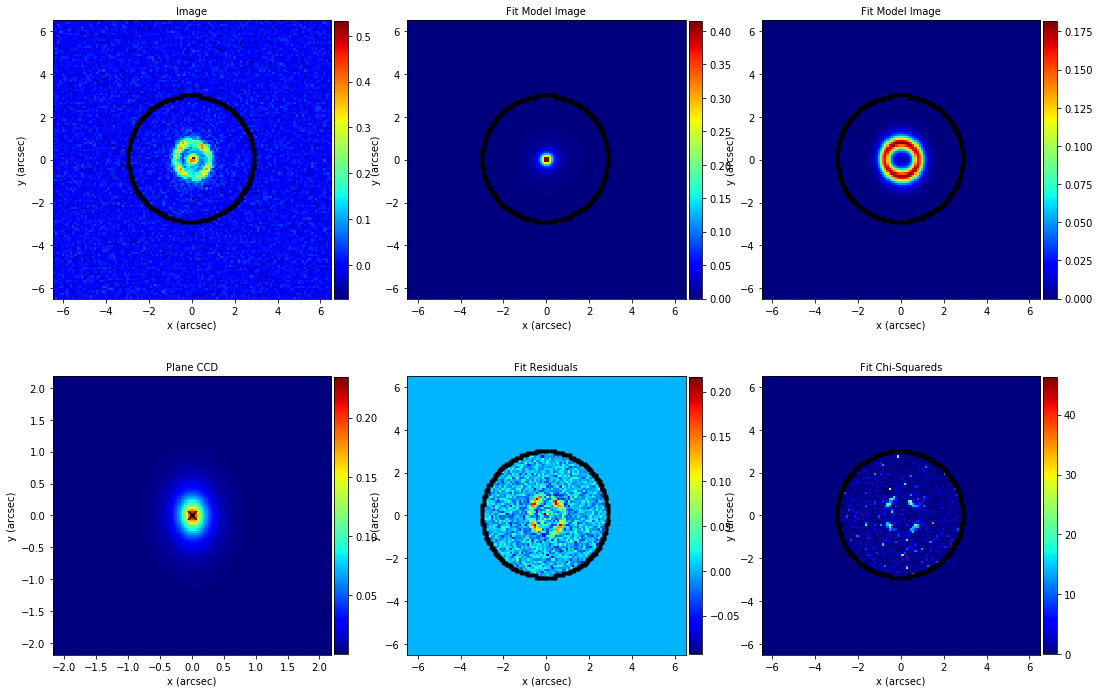

In [ ]:
lens_fit_plotters.plot_fit_subplot(fit=phase_1_results.most_likely_fit, should_plot_mask=True, extract_array_from_mask=True, 
                                   zoom_around_mask=True)

Now all we need to do is look at the results of phase 1 and tune our priors in phase 2 to those results. Lets setup a custom phase that does exactly that.

GaussianPriors are a nice way to do this. They tell the non-linear search where to look, but leave open the possibility that there might be a better solution nearby. In contrast, UniformPriors put hard limits on what values a parameter can or can't take - it makes it more likely we'll accidently cut-out the global likelihood solution.

In [27]:
class CustomPriorPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # What I've done here is looked at the results of phase 1, and manually specified a prior for every parameter.
        # If a parameter was fixed in the previous phase, its prior is based around the previous value. Don't worry
        # about the sigma values for now, I've chosen values that I know will ensure reasonable sampling, but we'll
        # cover this later.

        self.lens_galaxies.lens.light.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies.lens.light.centre_1 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies.lens.light.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.15)
        self.lens_galaxies.lens.light.phi = mm.GaussianPrior(mean=45.0, sigma=15.0)
        self.lens_galaxies.lens.light.intensity = mm.GaussianPrior(mean=0.02, sigma=0.01)
        self.lens_galaxies.lens.light.effective_radius = mm.GaussianPrior(mean=0.62, sigma=0.2)
        self.lens_galaxies.lens.light.sersic_index = mm.GaussianPrior(mean=4.0, sigma=2.0)

        self.lens_galaxies.lens.mass.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies.lens.mass.centre_1 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies.lens.mass.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.25)
        self.lens_galaxies.lens.mass.phi = mm.GaussianPrior(mean=45.0, sigma=30.0)
        self.lens_galaxies.lens.mass.einstein_radius = mm.GaussianPrior(mean=0.8, sigma=0.1)

        self.source_galaxies.source.light.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.source_galaxies.source.light.centre_1 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.source_galaxies.source.light.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.1)
        self.source_galaxies.source.light.phi = mm.GaussianPrior(mean=90.0, sigma=10.0)
        self.source_galaxies.source.light.intensity = mm.GaussianPrior(mean=0.14, sigma=0.05)
        self.source_galaxies.source.light.effective_radius = mm.GaussianPrior(mean=0.12, sigma=0.2)


Lets setup and run the phase. As expected, it gives us the correct lens model. However, it does so significantly faster than we're used to - I didn't have to edit the config files to get this phase to run fast!

In [28]:
phase_2 = CustomPriorPhase(phase_name='5_linking_phase_2', 
                           lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                   mass=mp.EllipticalIsothermal)),
                           source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                           optimizer_class=nl.MultiNest)

phase_2.optimizer.n_live_points = 30
phase_2.optimizer.sampling_efficiency = 0.9

print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/5_linking_phases'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
phase_2_results = phase_2.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/5_linking_phasesfolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


Look at that, the right lens model, again!

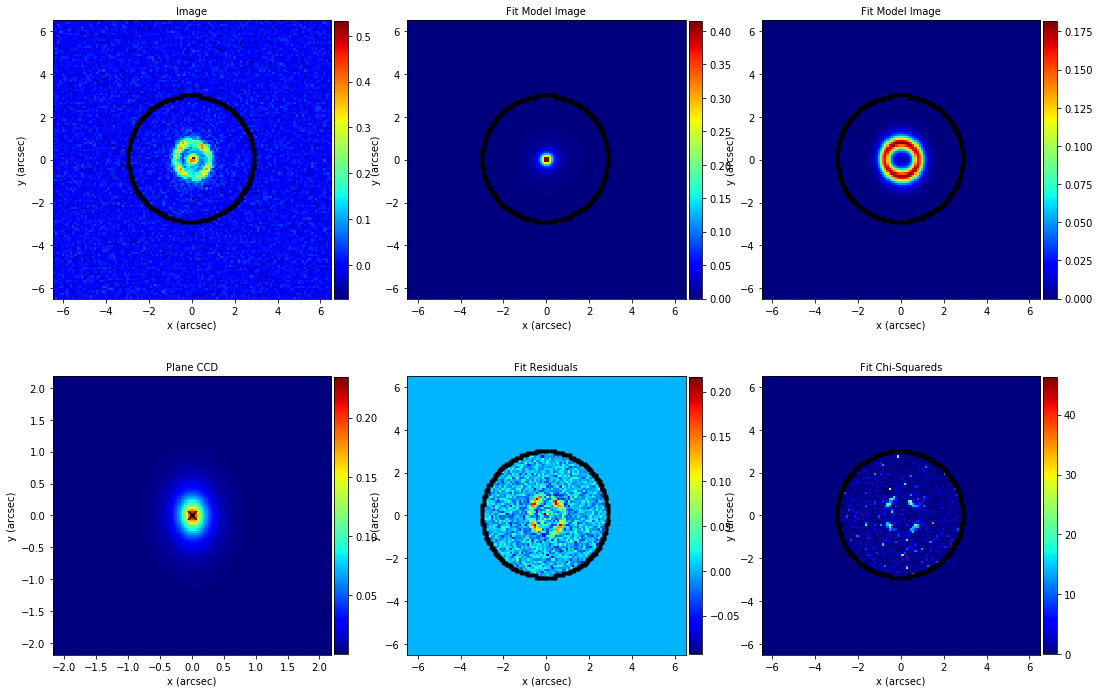

In [22]:
lens_fit_plotters.plot_fit_subplot(fit=phase_2_results.most_likely_fit, should_plot_mask=True, extract_array_from_mask=True, 
                                   zoom_around_mask=True)

Our choice to link two phases together was a huge success. We managed to fit a complex and realistic model, but were able to begin by making simplifying assumptions that eased our search of non-linear parameter space. We could apply phase 1 to pretty much any strong lens, and therefore get ourselves a decent lens model with which to tune phase 2's priors.

You're probably thinking though, that there is one huge, giant, glaring flaw in all of this that I've not mentioned. Phase 2 can't be generalized to another lens - it's priors are tuned to the image we fitted. If we had a lot of lenses, we'd have to write a new phase_2 for every single one. This isn't ideal, is it?

Well, let me reassure you, that PyAutoLens has you covered. In chapter 3, we'll cover 'pipelines'. As you might of guessed, a pipeline comprises a set of phases that are linked together. This allows us to start with a simple, easy-to-fit lens model, and gradually makes it more complex. Crucially, as the pipeline runs, we 'feed' the results of previous phases through the pipeline, allowing us to tune our priors automatically, in a way that can be applied generically to any strong lens.

However, before moving forward, there's a couple more thing we need to discuss - which revolve around run-speed. Lens modeling is a  computationally expensive process and keeping the run times on the order of days, or less, can be tricky. I'll give  you a sense of how we can do that in the next tutorial, and show you some neat tricks to get PyAutoLens modeling lenses super-fast after that! 

Before that, have a quick think about this - what might be the main factors driving a phase's run-time?